EPL Injury Analysis (Kaggle Dataset)
By: Janibek Magmurov

A project to research injuries in the English Premier League. The aim is to find out which injuries are the most severe, how they relate to player position and which injury categories cause the most downtime.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

#Filepath
research_file = '../data/raw/dataset_of_injuriesResearches.xlsx'
original_kaggle_file = '../data/raw/player_injuries_impact original KAGGLE.xlsx'
edited_kaggle_file = '../data/processed/player_injuries_impact(Edited).xlsx'

#Download Excell-Sheets
df_research = pd.read_excel(research_file)
df_kaggle_original = pd.read_excel(original_kaggle_file)
df_kaggle_edited = pd.read_excel(edited_kaggle_file)

#Creating database in data/processed
engine = create_engine('sqlite:///../data/processed/sql_injuries.db')

#Saving kaggle data to sql_injuries.db
df_kaggle_edited.to_sql('injuries', con = engine, index = False, if_exists = 'replace')

# Sorting data to one type (dd.mm.yy.)
df_kaggle_edited['Date of return'] = pd.to_datetime(
    df_kaggle_edited['Date of return'], 
    format='%d.%m.%Y', 
    errors='coerce'
)

text_cols = ['Position', 'Injury ', 'Injury Category']
for col in text_cols:
    df_kaggle_edited[col] = df_kaggle_edited[col].astype('category')

df_kaggle_edited['Downtime (days)'] = (
    df_kaggle_edited['Date of return'] - df_kaggle_edited['Date of Injury']
).dt.days

# Download of edited Kaggle-Dataset
df = pd.read_excel('../data/processed/player_injuries_impact(Edited).xlsx')

# Filtering: excluding Polytrauma
df_no_poly = df_kaggle_edited[df_kaggle_edited['Injury Category'] != 'Polytrauma']

# Define exact position order

position_order = [
    'Goalkeeper',
    'Left Back',
    'Center Back',
    'Right Back',
    'Left Midfielder',
    'Defensive Midfielder',
    'Central Midfielder',
    'Attacking Midfielder',
    'Right Midfielder',
    'Left winger',
    'Center Forward',
    'Right winger'
]

df_no_poly['Position'] = pd.Categorical(
    df_no_poly['Position'],
    categories=position_order,
    ordered=True
)

C:\Users\magmu\AppData\Local\Temp\ipykernel_18972\4229084146.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_poly['Position'] = pd.Categorical(


C:\Users\magmu\AppData\Local\Temp\ipykernel_18972\3676219038.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  downtime_by_injury = df_no_poly.groupby('Injury Category')['Downtime (days)'].mean().sort_values(ascending=False)


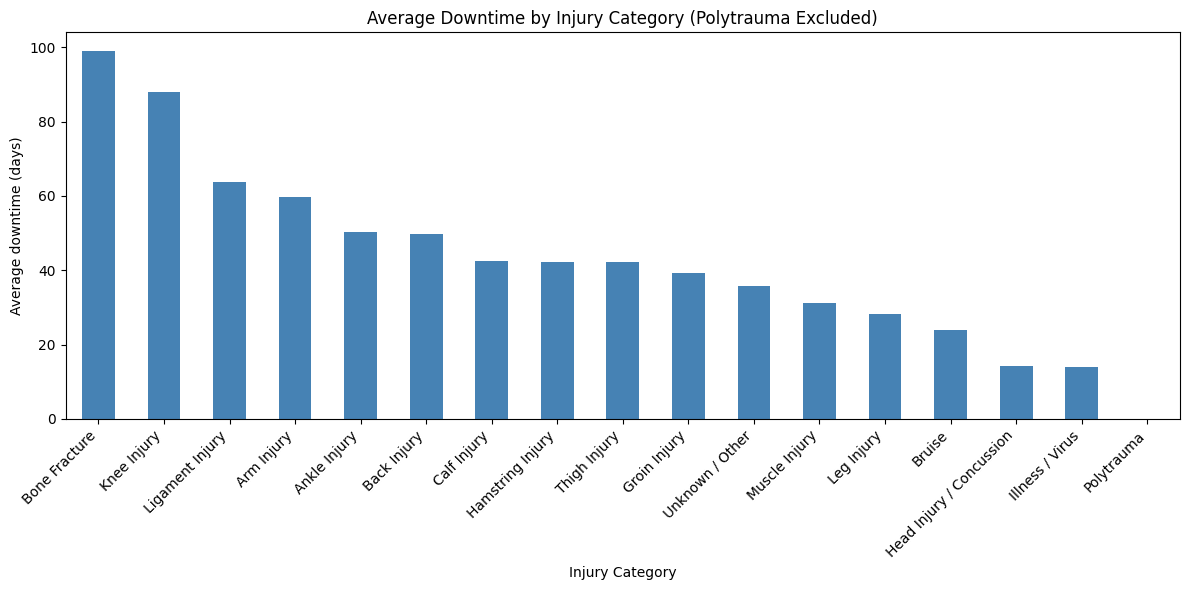

In [9]:
### Chart 1: Average by Injury Category ###

downtime_by_injury = df_no_poly.groupby('Injury Category')['Downtime (days)'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
downtime_by_injury.plot(kind='bar', color='steelblue')
plt.title('Average Downtime by Injury Category (Polytrauma Excluded)')
plt.ylabel('Average downtime (days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../visualizations/average_downtime_by_injury.png')
plt.show()

C:\Users\magmu\AppData\Local\Temp\ipykernel_18972\3063812502.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  downtime_stats = df_no_poly.groupby('Position')['Downtime (days)'].agg(['mean', 'median']).reindex(position_order)


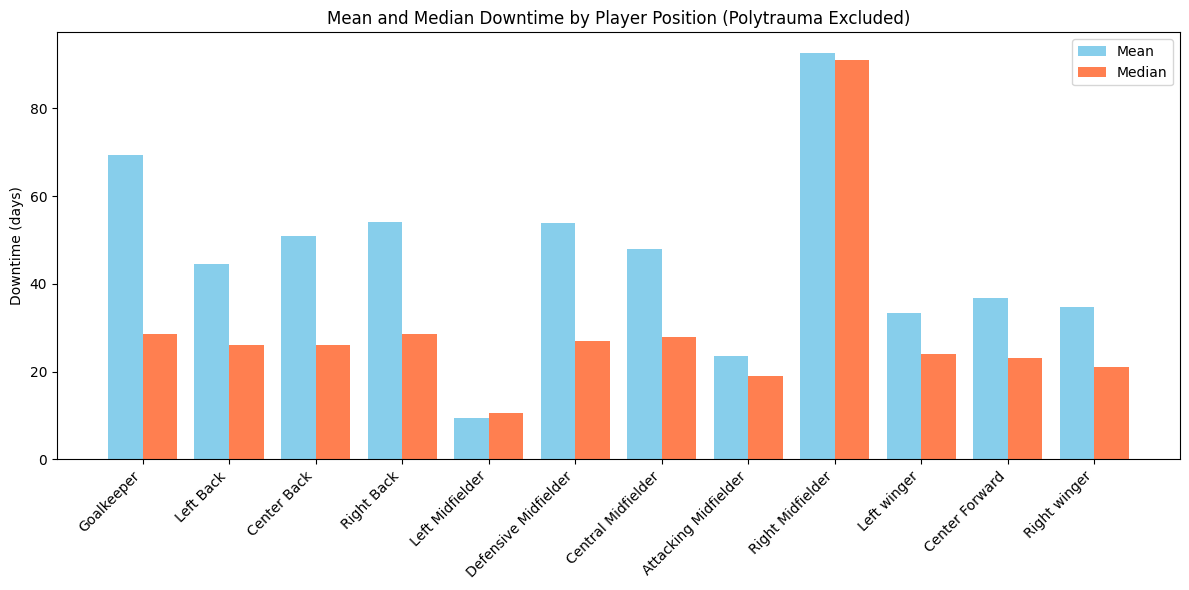

In [10]:
# Chart 2: Mean and Median by Position

downtime_stats = df_no_poly.groupby('Position')['Downtime (days)'].agg(['mean', 'median']).reindex(position_order) 

# Reset index to make the 'Position' column a normal column # 
downtime_stats = downtime_stats.reset_index()

plt.figure(figsize=(12,6))
bar_width = 0.4
positions = range(len(downtime_stats))

# Mean
plt.bar([p - bar_width/2 for p in positions], downtime_stats['mean'], width=bar_width, label='Mean', color='skyblue')

# Median
plt.bar([p + bar_width/2 for p in positions], downtime_stats['median'], width=bar_width, label='Median', color='coral')


plt.xticks(positions, downtime_stats['Position'], rotation=45, ha='right')
plt.ylabel('Downtime (days)')
plt.title('Mean and Median Downtime by Player Position (Polytrauma Excluded)')
plt.legend()
plt.tight_layout()
plt.savefig('../visualizations/downtime_by_position_mean_median.png')
plt.show()

C:\Users\magmu\AppData\Local\Temp\ipykernel_18972\1383456838.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


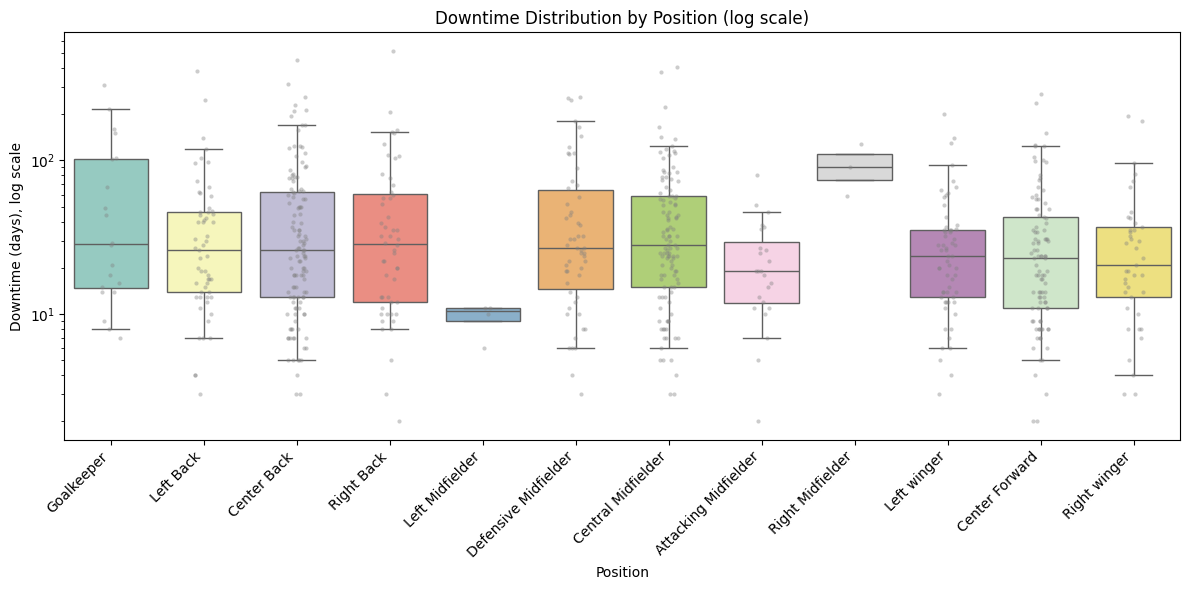

In [11]:
### Chart 3: Boxplot by Position ###


plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_no_poly,
    x='Position',
    y='Downtime (days)',
    palette='Set3',
    showfliers=False,
    whis=[5,95]
)
sns.stripplot(
    data=df_no_poly,
    x='Position',
    y='Downtime (days)',
    size=3,
    color='gray',
    alpha=0.4,
    jitter=True

)
plt.yscale('log')  
plt.title('Downtime Distribution by Position (log scale)')
plt.ylabel('Downtime (days), log scale')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../visualizations/downtime_distribution_by_position.png')
plt.show()

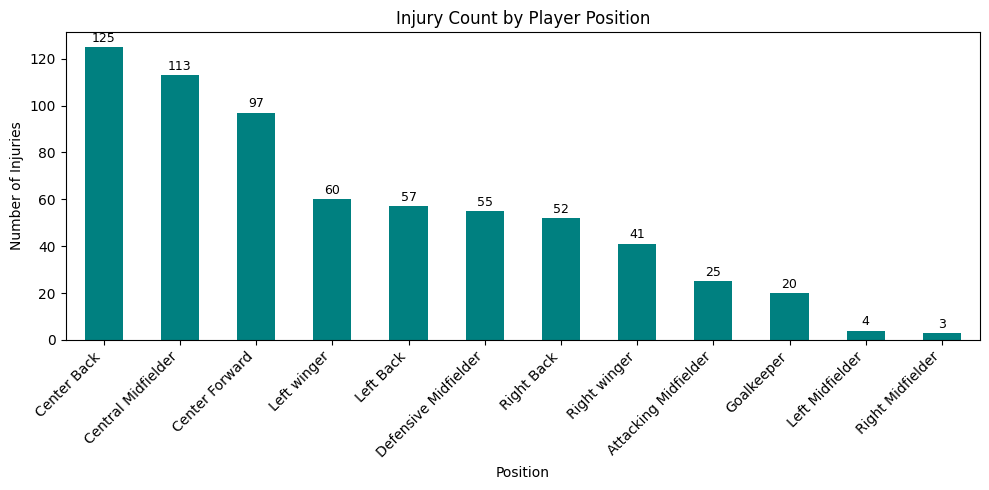

In [12]:
#Chart 4: Injury Count for Each Position

injury_counts = df_no_poly['Position'].value_counts().sort_values(ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
injury_counts.plot(kind='bar', color='teal')
ax = injury_counts.plot(kind='bar', color='teal')
plt.title('Injury Count by Player Position')
plt.xlabel('Position')
plt.ylabel('Number of Injuries')
plt.xticks(rotation=45, ha='right')
for i, count in enumerate(injury_counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=9, color='black')
plt.tight_layout()
plt.savefig('../visualizations/injury_count_by_position.png')
plt.show()

In [13]:
# Pivot Table 1:  Injury Type Distribution for Each Position

injury_type_by_pos = pd.pivot_table(
    df_no_poly, 
    index='Position',
    columns='Injury Category',
    values='Downtime (days)', 
    aggfunc='count',
    fill_value=0
)

print(injury_type_by_pos)

Injury Category       Ankle Injury  Arm Injury  Back Injury  Bone Fracture  \
Position                                                                     
Goalkeeper                       0           4            1              0   
Left Back                        6           3            0              0   
Center Back                     20           2            4              2   
Right Back                       9           2            2              2   
Left Midfielder                  0           0            0              0   
Defensive Midfielder            10           1            3              2   
Central Midfielder              14           2            1              0   
Attacking Midfielder             4           0            0              1   
Right Midfielder                 1           1            0              0   
Left winger                      8           1            1              2   
Center Forward                   8           0            2     

C:\Users\magmu\AppData\Local\Temp\ipykernel_18972\3939355391.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  injury_type_by_pos = pd.pivot_table(


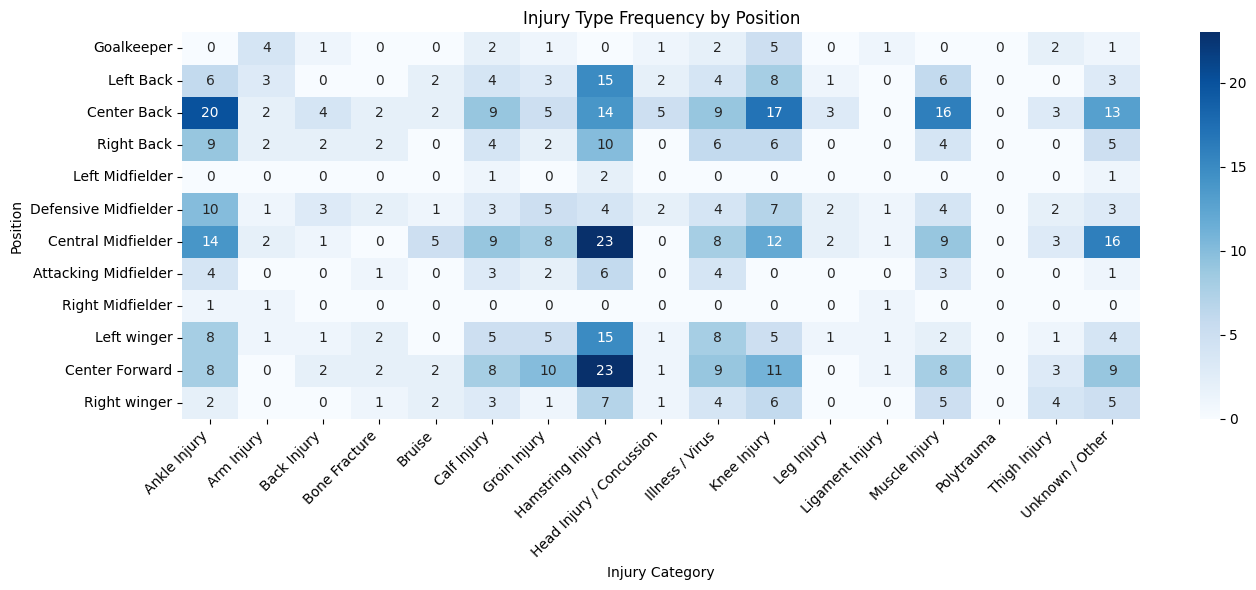

In [14]:
# Heatmap 1: Injury Type Distribution for Each Position 

import seaborn as sns

plt.figure(figsize=(14,6))
sns.heatmap(injury_type_by_pos, annot=True, fmt='d', cmap='Blues')
plt.title('Injury Type Frequency by Position')
plt.xlabel('Injury Category')
plt.ylabel('Position')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../visualizations/heatmap_injury_type_for_position.png')
plt.show()

Conclusion

This analysis explores the recovery time after injuries among English Premier League football players by position. The findings here are intended primarily for my self-education in data analysis and programming. Please note that the hypotheses discussed have no scientific validity—they are based on personal reasoning and a limited dataset, without confirmation from external sources or formal statistical tests. The main aim of this project is skill development in analytics and coding.

Goalkeepers:
Goalkeepers exhibit one of the highest median recovery times and the widest range between minor and severe injuries. This suggests that although goalkeepers are injured less often, their injuries tend to be more serious, such as fractures or ligament damage from collisions or dives. This highlights the importance of specialized prevention and training for this role.

Defenders (center, left, right):
Defenders show moderate median and mean recovery times, but with significant spread. This is explained by their frequent physical battles, blocking shots, and risks of knee, ankle, or muscle injuries. Central defenders, in particular, often suffer the most severe injuries.

Midfielders (central, attacking, defensive):
Central and attacking midfielders display medium median and mean downtimes, with considerable variation. These positions demand high activity in both defense and attack, and the diversity of injuries reflects their versatile roles. Defensive midfielders in this dataset show relatively shorter and more consistent recovery times.

Wide midfielders (left and right):
The left and right midfielder positions have too little data (only 3–4 injuries) to allow reliable conclusions. Their low median and mean recovery times may indicate lower injury risk, faster recovery, or simply underrepresentation in the dataset. These explanations are only hypotheses.

Wingers and center forwards:
Wingers and center forwards have moderate median recovery times, often lower than defenders and goalkeepers. This may reflect a higher proportion of muscle or minor injuries, typical for roles with sprinting and high-intensity flank play.

Additional findings (from injury frequency and type analysis):
Center backs and central midfielders suffer the most injuries overall. The most typical injuries for these roles are muscle strains, knee and ankle injuries—consistent with the expected demands of their positions. Goalkeepers have a unique injury profile, with more frequent arm and groin injuries. Wide midfielders and wingers have the fewest injuries, supporting the hypothesis of lower involvement or unique tactical roles.

General remark:
All conclusions and hypotheses here are for educational purposes only and are not supported by formal statistical testing or external validation. The limited sample size, especially for some positions, restricts the reliability of the findings. Future work could benefit from larger datasets and more detailed analysis by injury type and player involvement.

